In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import train_test_split

from torchvision import datasets, transforms
import torchinfo 

/home/e.babenko1/miniconda3/envs/AIenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))],
)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip()]
)
batch_size = 128
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
epochs = 35

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_set = datasets.CIFAR10(
    root='./dataset', train=True, download=True, transform=train_transform)
valid_set = datasets.CIFAR10(
    root='./dataset', train=True, download=True, transform=train_transform)
test_set = datasets.CIFAR10(
    root='./dataset', train=False, download=True, transform=transform)

train_idx, valid_idx   = train_test_split(range(len(train_set)), test_size=0.2, train_size=0.8)
# idxs = list(range(len(train_set)))
# split = int(np.floor(0.2*len(train_set)))
# valid_idx, train_idx = idxs[:split], idxs[split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
num_workers = 2

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(
    valid_set, batch_size=batch_size, num_workers=num_workers, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, num_workers=num_workers)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.shuffle1 = nn.Sequential(nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        ), nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True))
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.shuffle2 = nn.Sequential(nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        ), nn.Sequential(
            nn.Conv2d(512, 512,3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True))
        )

        self.res = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(512, len(classes))
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.shuffle1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.shuffle2(x) + x
        x = self.res(x)
        return x


In [4]:
model = Model()

try:
    print(torchinfo.summary(model, input_size=(batch_size, 3, 32, 32)))
except RuntimeError as a:
    print(a)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

model.to(device)


criterion = nn.CrossEntropyLoss()
from torch.optim.lr_scheduler import ReduceLROnPlateau
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = ReduceLROnPlateau(optim, 'min')


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [128, 10]                 --
├─Sequential: 1-1                        [128, 64, 32, 32]         --
│    └─Conv2d: 2-1                       [128, 64, 32, 32]         1,792
│    └─BatchNorm2d: 2-2                  [128, 64, 32, 32]         128
│    └─ReLU: 2-3                         [128, 64, 32, 32]         --
├─Sequential: 1-2                        [128, 128, 16, 16]        --
│    └─Conv2d: 2-4                       [128, 128, 32, 32]        73,856
│    └─BatchNorm2d: 2-5                  [128, 128, 32, 32]        256
│    └─ReLU: 2-6                         [128, 128, 32, 32]        --
│    └─MaxPool2d: 2-7                    [128, 128, 16, 16]        --
├─Sequential: 1-3                        [128, 128, 16, 16]        --
│    └─Sequential: 2-8                   [128, 128, 16, 16]        --
│    │    └─Conv2d: 3-1                  [128, 128, 16, 16]        147,584
│

In [5]:
def train_step():
    model.train()
    running_loss = 0.
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optim.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optim.step()
        running_loss += loss
    with torch.no_grad():
        train_loss = running_loss / len(train_loader)
    return train_loss.item()


def valid_step():
    model.eval()
    correct_total = 0
    running_loss = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            prediction = output.max(dim=1, keepdim=True)[1]
            correct_total += prediction.eq(labels.view_as(prediction)).sum()
            loss = criterion(output, labels)
            running_loss += loss
        valid_loss = running_loss / len(valid_loader)
        accuracy = correct_total / len(valid_sampler)
        return valid_loss.item(), accuracy.item()


train_losses = []
valid_losses = []
valid_accs = []


In [6]:
from tqdm import tqdm

best_loss = 10000

for epoch in (pbar := tqdm(range(epochs))):
    train_loss = train_step()
    valid_loss, valid_acc = valid_step()
    scheduler.step(valid_loss)

    if valid_loss < best_loss and  epoch > 3:
        best_loss = valid_loss
        print(f"Saved loss with acc: {valid_acc} | loss: {valid_loss}")
        torch.save(model.state_dict(), f"./cifar_temp{epoch}.pth")

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    pbar.set_description(
        f'[{epoch}] Acc: {valid_acc:.4f}  Avg. train/valid loss: {train_loss:.4f}/{valid_loss:.4f}\n')


PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)


[0] Acc: 0.3638  Avg. train/valid loss: 2.7597/1.9217
[0] Acc: 0.3638  Avg. train/valid loss: 2.7597/1.9217
[1] Acc: 0.5646  Avg. train/valid loss: 1.5691/1.2261
[1] Acc: 0.5646  Avg. train/valid loss: 1.5691/1.2261
[2] Acc: 0.6126  Avg. train/valid loss: 1.2102/1.2027
[2] Acc: 0.6126  Avg. train/valid loss: 1.2102/1.2027
[3] Acc: 0.6498  Avg. train/valid loss: 0.9963/0.9824
[3] Acc: 0.6498  Avg. train/valid loss: 0.9963/0.9824
[4] Acc: 0.7240  Avg. train/valid loss: 0.8289/0.8590
[4] Acc: 0.7240  Avg. train/valid loss: 0.8289/0.8590
:  14%|█▍        | 5/35 [01:07<06:23, 12.80s/it]

Saved loss with acc: 0.7239999771118164 | loss: 0.8589808940887451


[5] Acc: 0.7304  Avg. train/valid loss: 0.7310/0.8159
[5] Acc: 0.7304  Avg. train/valid loss: 0.7310/0.8159
:  17%|█▋        | 6/35 [01:19<06:03, 12.52s/it]

Saved loss with acc: 0.7303999662399292 | loss: 0.8159216642379761


[6] Acc: 0.7344  Avg. train/valid loss: 0.6591/0.8620
[6] Acc: 0.7344  Avg. train/valid loss: 0.6591/0.8620
[7] Acc: 0.7797  Avg. train/valid loss: 0.6164/0.7181
[7] Acc: 0.7797  Avg. train/valid loss: 0.6164/0.7181
:  23%|██▎       | 8/35 [01:44<05:34, 12.39s/it]

Saved loss with acc: 0.779699981212616 | loss: 0.7180628180503845


[8] Acc: 0.7857  Avg. train/valid loss: 0.5569/0.7122
[8] Acc: 0.7857  Avg. train/valid loss: 0.5569/0.7122
:  26%|██▌       | 9/35 [01:56<05:21, 12.36s/it]

Saved loss with acc: 0.7856999635696411 | loss: 0.71222984790802


[9] Acc: 0.8258  Avg. train/valid loss: 0.5114/0.5185
[9] Acc: 0.8258  Avg. train/valid loss: 0.5114/0.5185
:  29%|██▊       | 10/35 [02:09<05:09, 12.39s/it]

Saved loss with acc: 0.8258000016212463 | loss: 0.5185104012489319


[10] Acc: 0.8252  Avg. train/valid loss: 0.4659/0.5346
[10] Acc: 0.8252  Avg. train/valid loss: 0.4659/0.5346
[11] Acc: 0.8208  Avg. train/valid loss: 0.4410/0.5385
[11] Acc: 0.8208  Avg. train/valid loss: 0.4410/0.5385
[12] Acc: 0.8113  Avg. train/valid loss: 0.4078/0.5825
[12] Acc: 0.8113  Avg. train/valid loss: 0.4078/0.5825
[13] Acc: 0.8342  Avg. train/valid loss: 0.3652/0.5145
[13] Acc: 0.8342  Avg. train/valid loss: 0.3652/0.5145
:  40%|████      | 14/35 [02:58<04:20, 12.38s/it]

Saved loss with acc: 0.8341999650001526 | loss: 0.5145339369773865


[14] Acc: 0.8548  Avg. train/valid loss: 0.3550/0.4509
[14] Acc: 0.8548  Avg. train/valid loss: 0.3550/0.4509
:  43%|████▎     | 15/35 [03:11<04:07, 12.38s/it]

Saved loss with acc: 0.8547999858856201 | loss: 0.45087313652038574


[15] Acc: 0.8699  Avg. train/valid loss: 0.3357/0.4167
[15] Acc: 0.8699  Avg. train/valid loss: 0.3357/0.4167
:  46%|████▌     | 16/35 [03:23<03:54, 12.35s/it]

Saved loss with acc: 0.8698999881744385 | loss: 0.41667118668556213


[16] Acc: 0.8424  Avg. train/valid loss: 0.3199/0.5057
[16] Acc: 0.8424  Avg. train/valid loss: 0.3199/0.5057
[17] Acc: 0.8672  Avg. train/valid loss: 0.2977/0.4108
[17] Acc: 0.8672  Avg. train/valid loss: 0.2977/0.4108
:  51%|█████▏    | 18/35 [03:49<03:34, 12.63s/it]

Saved loss with acc: 0.8671999573707581 | loss: 0.41076961159706116


[18] Acc: 0.8568  Avg. train/valid loss: 0.2794/0.4414
[18] Acc: 0.8568  Avg. train/valid loss: 0.2794/0.4414
[19] Acc: 0.8550  Avg. train/valid loss: 0.2607/0.4776
[19] Acc: 0.8550  Avg. train/valid loss: 0.2607/0.4776
[20] Acc: 0.8737  Avg. train/valid loss: 0.2575/0.4236
[20] Acc: 0.8737  Avg. train/valid loss: 0.2575/0.4236
[21] Acc: 0.8695  Avg. train/valid loss: 0.2275/0.4266
[21] Acc: 0.8695  Avg. train/valid loss: 0.2275/0.4266
[22] Acc: 0.8607  Avg. train/valid loss: 0.2151/0.5030
[22] Acc: 0.8607  Avg. train/valid loss: 0.2151/0.5030
[23] Acc: 0.8709  Avg. train/valid loss: 0.2171/0.4128
[23] Acc: 0.8709  Avg. train/valid loss: 0.2171/0.4128
[24] Acc: 0.8686  Avg. train/valid loss: 0.1989/0.4446
[24] Acc: 0.8686  Avg. train/valid loss: 0.1989/0.4446
[25] Acc: 0.8816  Avg. train/valid loss: 0.1856/0.3983
[25] Acc: 0.8816  Avg. train/valid loss: 0.1856/0.3983
:  74%|███████▍  | 26/35 [05:39<01:58, 13.15s/it]

Saved loss with acc: 0.8815999627113342 | loss: 0.3982512056827545


[26] Acc: 0.8876  Avg. train/valid loss: 0.1707/0.3821
[26] Acc: 0.8876  Avg. train/valid loss: 0.1707/0.3821
:  77%|███████▋  | 27/35 [05:51<01:43, 12.90s/it]

Saved loss with acc: 0.8876000046730042 | loss: 0.3821395933628082


[27] Acc: 0.8770  Avg. train/valid loss: 0.1778/0.4201
[27] Acc: 0.8770  Avg. train/valid loss: 0.1778/0.4201
[28] Acc: 0.8880  Avg. train/valid loss: 0.1641/0.3851
[28] Acc: 0.8880  Avg. train/valid loss: 0.1641/0.3851
[29] Acc: 0.8856  Avg. train/valid loss: 0.1587/0.3995
[29] Acc: 0.8856  Avg. train/valid loss: 0.1587/0.3995
[30] Acc: 0.8868  Avg. train/valid loss: 0.1441/0.3933
[30] Acc: 0.8868  Avg. train/valid loss: 0.1441/0.3933
[31] Acc: 0.8767  Avg. train/valid loss: 0.1408/0.4486
[31] Acc: 0.8767  Avg. train/valid loss: 0.1408/0.4486
[32] Acc: 0.8921  Avg. train/valid loss: 0.1214/0.3857
[32] Acc: 0.8921  Avg. train/valid loss: 0.1214/0.3857
[33] Acc: 0.8842  Avg. train/valid loss: 0.1230/0.4259
[33] Acc: 0.8842  Avg. train/valid loss: 0.1230/0.4259
[34] Acc: 0.8837  Avg. train/valid loss: 0.1073/0.4332
[34] Acc: 0.8837  Avg. train/valid loss: 0.1073/0.4332
[34] Acc: 0.8837  Avg. train/valid loss: 0.1073/0.4332
: 100%|██████████| 35/35 [07:30<00:00, 12.88s/it]


Text(0, 0.5, 'Loss')

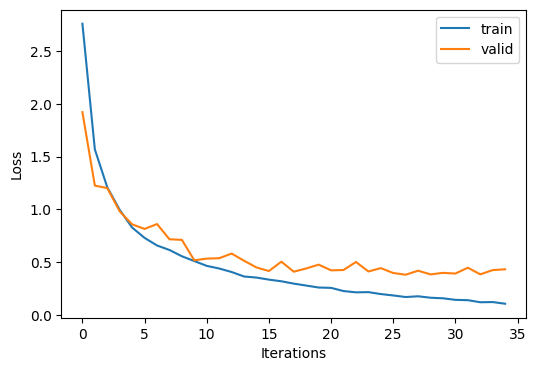

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')


Text(0, 0.5, 'Accuracy')

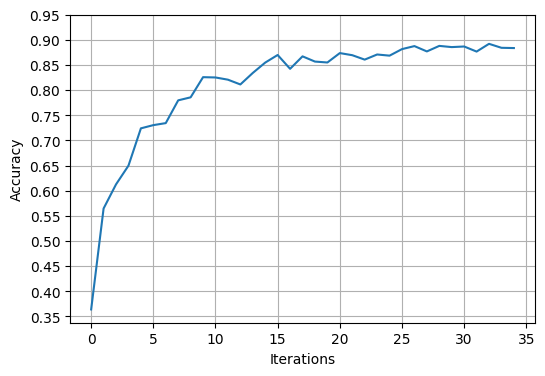

In [8]:
fig = plt.figure(figsize=(6, 4))

plt.plot(valid_accs)
plt.yticks(np.arange(0.35, 1, 0.05))
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')


In [17]:
model = nn.DataParallel(Model())
model.load_state_dict(torch.load("cifar_temp26.pth"))
model.to(device)

def test_accuracy_per_class(model, testloader):
    correct_pred = {classname: 0 for classname in train_set.classes}
    total_pred = {classname: 0 for classname in train_set.classes}

    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs.data, 1)[1]

            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[train_set.classes[label]] += 1
                total_pred[train_set.classes[label]] += 1
    
    accuracy_per_class = {classname: 0 for classname in train_set.classes}
    for classname, correct_count in correct_pred.items():
        accuracy = (100 * float(correct_count)) / total_pred[classname]
        accuracy_per_class[classname] = accuracy

    return accuracy_per_class

for classname, accuracy in test_accuracy_per_class(model, test_loader).items():
    print(f'{classname:12s} {accuracy:.2f} %')




airplane     89.80 %
automobile   95.30 %
bird         87.30 %
cat          80.70 %
deer         91.20 %
dog          81.10 %
frog         92.50 %
horse        88.50 %
ship         95.80 %
truck        90.90 %
